In [1]:
import os
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [2]:
batch_size = 32
num_workers = 0

transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
data = datasets.ImageFolder('./dataset/', transform=transform)

train_set, test_set = torch.utils.data.random_split(data, [1076, 300])

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

class_names = ['with_mask', 'without_mask']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

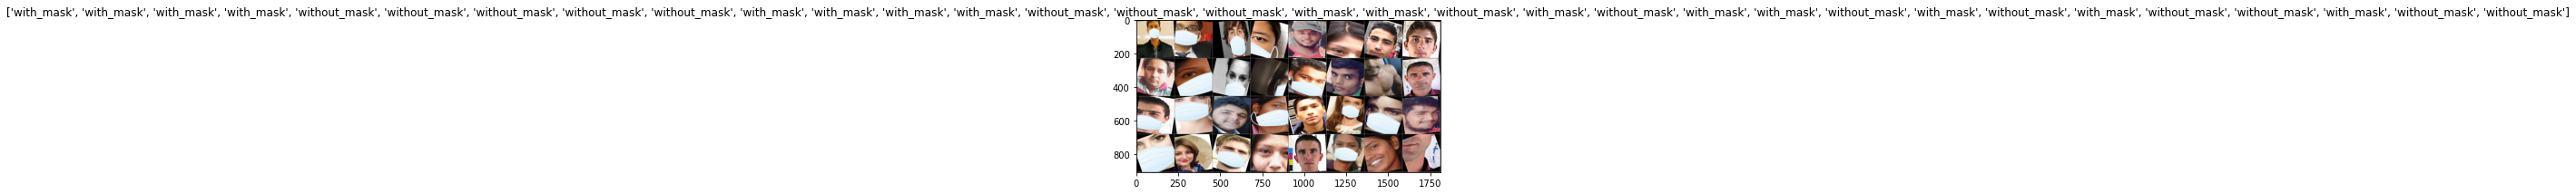

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
model = models.mobilenet_v2(pretrained=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()
    
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [7]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(1280,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,2),
                                       torch.nn.Softmax()
                                      )

for param in model.classifier.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model_transfer.cuda()
    
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0001)

In [9]:
n_epochs = 25

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, use_cuda, save_path):
    
    valid_loss_min = np.Inf
       
    for epoch in range(1, (n_epochs+1)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        train_acc = train_acc/len(loaders['train'].dataset)
        valid_acc = valid_acc/len(loaders['valid'].dataset)
        
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  
            
    return model

In [10]:
model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, './trained-models/model_transfer.pt')

/home/saksham/anaconda3/envs/torch36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Acc: 0.857807 	Training Loss: 0.000532 	Validation Acc: 0.960000 	Validation Loss: 0.001502
Validation loss decreased (inf --> 0.001502).  Saving model ...
Epoch: 2 	Training Acc: 0.936803 	Training Loss: 0.000403 	Validation Acc: 0.950000 	Validation Loss: 0.001331
Validation loss decreased (0.001502 --> 0.001331).  Saving model ...
Epoch: 3 	Training Acc: 0.936803 	Training Loss: 0.000375 	Validation Acc: 0.966667 	Validation Loss: 0.001266
Validation loss decreased (0.001331 --> 0.001266).  Saving model ...
Epoch: 4 	Training Acc: 0.950743 	Training Loss: 0.000358 	Validation Acc: 0.953333 	Validation Loss: 0.001262
Validation loss decreased (0.001266 --> 0.001262).  Saving model ...
Epoch: 5 	Training Acc: 0.944238 	Training Loss: 0.000357 	Validation Acc: 0.956667 	Validation Loss: 0.001241
Validation loss decreased (0.001262 --> 0.001241).  Saving model ...
Epoch: 6 	Training Acc: 0.954461 	Training Loss: 0.000347 	Validation Acc: 0.943333 	Validation Loss: 0.0

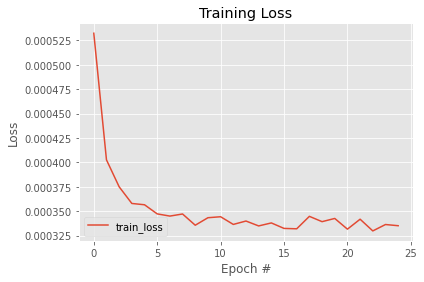

In [12]:
plt.style.use("ggplot")
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

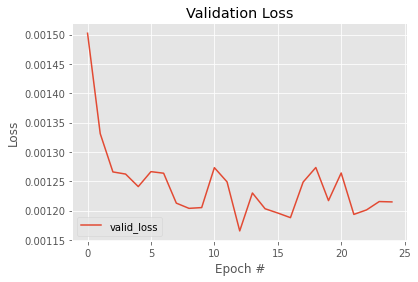

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(valid_loss_list, label="valid_loss")

plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

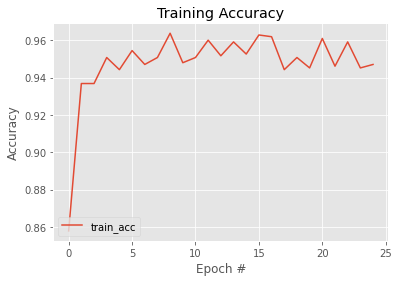

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(train_accuracy_list, label="train_acc")

plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

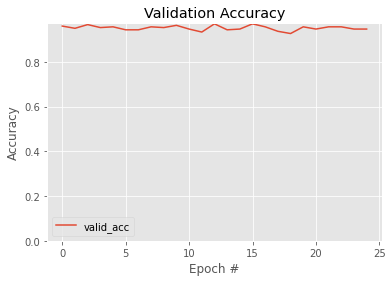

In [15]:
plt.style.use("ggplot")
plt.figure()
plt.plot(valid_accuracy_list, label="valid_acc")
plt.ylim(ymin=0)

plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [37]:
torch.save(model, './trained-models/model_final.pth')

In [32]:
from PIL import Image

class_names = ['with_mask', 'without_mask']

def predict(image):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    
    #model.eval()
    idx = torch.argmax(model(image))
    
    return class_names[idx]

In [33]:

def run_app(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    prediction = predict(img_path)
    print("The Person is ".format(prediction))  

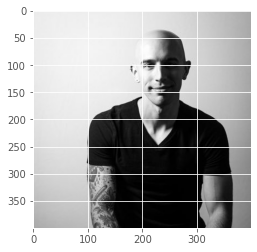

/home/saksham/anaconda3/envs/torch36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


The Person is 


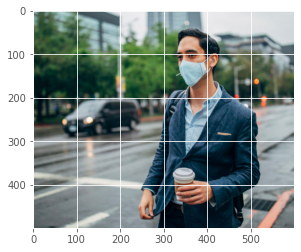

The Person is 


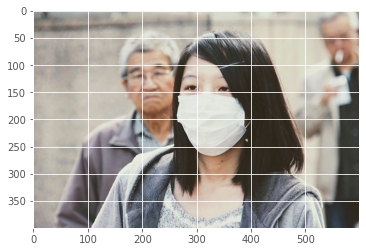

The Person is 


In [34]:
for img_file in os.listdir('./examples/'):
    img_path = os.path.join('./examples', img_file)
    run_app(img_path)